In [34]:
import pandas as pd
import numpy as np
import glob
import os
from scipy import stats
import tensorflow as tf
import math
import random
import matplotlib.pyplot as plt

fps = 120
moving_avg_len = 10
filter_value = 20
length = 150
threshold_pattern=0.6
#10.11. 목



def readFileData(file):
    column_names = ['wmx1', 'wmy1', 'wmz1']

    data = pd.read_csv(file, skiprows = 1 , names = column_names)
 
    wx = data["wmx1"]
    wy = data["wmy1"]
    wz = data["wmz1"]

    records=movingavg(wx,wy,wz)

    return np.dstack([wx,wy,wz])[0]

def readData(directory):
    records = []
    labels = np.empty(0)
    allFiles = glob.glob("*.csv")
    for i,file in enumerate(allFiles):
        fileName = os.path.basename(file)
        print("file name is", fileName,"\nnum is",i)
        (name, ext) = os.path.splitext(fileName)
        print("name is ",name,"ext is",ext)
        parts = name.split("_")
        if (True):
            label=parts[]
            fileData = readFileData(file)
            records.append(fileData)
            print("file data is ",fileData)
            labels=np.append(labels,label)

    print("* labels : ", labels)
    return (records, labels)

def movingavg(x,y,z):
    x_avg = np.zeros(moving_avg_len)/moving_avg_len
    y_avg = np.zeros(moving_avg_len)/moving_avg_len
    z_avg = np.zeros(moving_avg_len)/moving_avg_len
    x_avg = np.convolve(x,x_avg,'same')
    y_avg = np.convolve(y,y_avg,'same')
    z_avg = np.convolve(z,z_avg,'same')
    
    return [x_avg,y_avg,z_avg]

def splitData(records):##sungshil
    
    print("records[0][0] is ",records[0][0])
    term=fps // 24
    record_sum = []
    record = []
    record_all = []
    sum_now = 0
    sum_pre = 0
    ct = 0
    start = 0
    end = 0
    
    for i in range((len(records[0])//(term))-100):
        sum = 0
        record_x = np.empty(shape=[1],dtype=float)
        record_y = np.empty(shape=[1],dtype=float)
        record_z = np.empty(shape=[1],dtype=float)
        for j in range(fps//2):
            record_x = np.append(record_x,records[0][term*i+j][0])
            record_y = np.append(record_y,records[0][term*i+j][1])
            record_z = np.append(record_z,records[0][term*i+j][2])
        for k in range(fps//2 - 2):
            sum = sum+(record_x[k]-record_x[k+1])**2+(record_y[k]-record_y[k+1])**2+(record_z[k]-record_z[k+1])**2
            
        sum_pre = sum_now
        sum_now = sum
        record_sum.append(sum)
        if (sum_pre < threshold_pattern and sum_now > threshold_pattern):
            start = term * i
        if (sum_pre > threshold_pattern and sum_now < threshold_pattern):
            end = term * i  
            s = []
            if (end-start)>120:
                ct = ct + 1
                print(">> start : ",start)
                print(" >> end : ",end,", step : " ,ct, ", length of end-start : ",(end-start))
                for k in range(end-start):
                    #t=(records[0][term*i+j+k])
                    #print("t is",t)
                    s.append(records[0][start+k])
                    #print("s is ",s)
                record_all.append(s)
             
    print("number of patterm : ",ct)
    #print("average is",np.average(record_sum))
    

    plt.plot(record_sum[1500:2000])



   
    return record_all

def getRecordsMaxLength(records):
    maxLen = 0
    for record in records:
        if (len(record) > maxLen):
            maxLen = len(record)
        
    return maxLen

def shortenRecordsLen(records, length):
    ret = []
    rec_len = len(records)
    
    for index in range(len(records)):
        if (records[index]>length):
            s = []
            record = records[index]
            if len(record)<3000:
                for i in range(length):
                    r=[]
                    t=i*(len(record)/length)
                    if t%1 == 0:
                        s.append(records[index][int(t)])
                    else:
                        a = t//1
                        s1 = t-a
                        s2 = a+1-t
                        for i in range(3):
                            r.append(s1*records[index][int(a)][i]+s2*records[index][int(a)][i])
                        s.append(r)                       
            ret.append(s)
            
        elif(records[index]<length):
            s=[]
            record=records[index]
            if len(record)>0:
                for i in range(length):
                    r=[]
                    t=(length/len(record))*i
                    if t%1==0:
                        s.append(records[index][int(i)])
                    else:
                        
            
    
    
        for index in range(len(records)):
            s = []
            record = records[index]
            if len(record) > length and len(record)<3000:
                for i in range(length):
                    r=[]
                    t=i*len(record)/length
                    if t%1 == 0:
                        s.append(records[index][int(t)])
                    else:
                        a = t//1
                        s1 = t-a
                        s2 = a+1-t
                        for i in range(3):
                            r.append(s1*records[index][int(a)][i]+s2*records[index][int(a)][i])
                        s.append(r)                       
            ret.append(s)

    return ret

def weight_variable(shape):#가중치 생성
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):#편향 생성
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):#각 채널마다 활성곱 수행후 ReLu활성화 함수로 pass
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):#생성된 convolution층에 pooling 적용
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

file name is Converted_triangle_Goeun.csv 
num is 0
name is  Converted_triangle_Goeun ext is .csv
file data is  [[-0.4037555 -0.4533244  0.123958 ]
 [-0.4037032 -0.453312   0.1240349]
 [-0.4036419 -0.4533651  0.1239233]
 ...
 [-0.5039639  0.2422239  0.3849714]
 [-0.5024952  0.233694   0.3909167]
 [-0.5009295  0.2242776  0.3971767]]
file name is Converted_triangle_Sua.csv 
num is 1
name is  Converted_triangle_Sua ext is .csv
file data is  [[-0.4566614  0.3063586  0.4218905]
 [-0.4566169  0.3065761  0.4217441]
 [-0.4567036  0.3068056  0.4214881]
 ...
 [-0.4183478  0.3121404  0.2459875]
 [-0.4226401  0.3115721  0.245495 ]
 [-0.4270472  0.3110253  0.2447947]]
file name is Converted_triangle_Sungshil.csv 
num is 2
name is  Converted_triangle_Sungshil ext is .csv
file data is  [[-0.4308836  0.285009   0.3843815]
 [-0.4309311  0.2851806  0.384151 ]
 [-0.4310462  0.2853804  0.3838755]
 ...
 [-0.4077535  0.3494152  0.3543387]
 [-0.4078825  0.3482983  0.3551371]
 [-0.4076465  0.3459024  0.357711

>> start :  34155
 >> end :  35080 , step :  83 , length of end-start :  925
>> start :  35095
 >> end :  35290 , step :  84 , length of end-start :  195
>> start :  35305
 >> end :  36395 , step :  85 , length of end-start :  1090
>> start :  36455
 >> end :  36725 , step :  86 , length of end-start :  270
>> start :  36755
 >> end :  37320 , step :  87 , length of end-start :  565
>> start :  37370
 >> end :  37660 , step :  88 , length of end-start :  290
>> start :  37725
 >> end :  38675 , step :  89 , length of end-start :  950
>> start :  38690
 >> end :  40190 , step :  90 , length of end-start :  1500
>> start :  40210
 >> end :  40525 , step :  91 , length of end-start :  315
>> start :  40545
 >> end :  41855 , step :  92 , length of end-start :  1310
>> start :  41880
 >> end :  42495 , step :  93 , length of end-start :  615
number of patterm :  93
labels_converted : ['triangle' 'triangle' 'triangle' 'X' 'X' 'X']
labels_converted : [[0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]

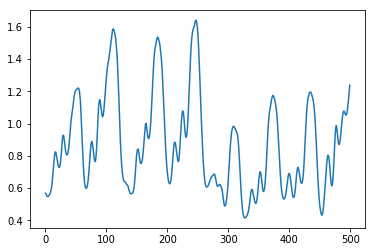

In [35]:
(records,labels) = readData("dr")
print("**len_record : ",len(records))
records = splitData(records)
records = shortenRecordsLen(records, length)
print("labels_converted :" ,labels)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
print("labels_converted :" ,labels)
len_label=len(records)



In [ ]:
for i in range(len(records)):
    plt.plot(records[i][2])

In [3]:
records = np.asarray(records)
reshaped_records = records.reshape(len(records),1,200, 3) #recoed를 1차원으로 reshape
print(reshaped_records)

[[[[-0.247097   -0.3659703   0.4844977 ]
   [-0.2472932  -0.3657586   0.4846356 ]
   [-0.2476161  -0.365464    0.48479   ]
   ...
   [ 0.02517822  0.1576575   0.4624478 ]
   [ 0.01866563  0.1680359   0.4599203 ]
   [ 0.01163944  0.1779995   0.4573621 ]]]


 [[[-0.453598   -0.105699    0.4544878 ]
   [-0.4538267  -0.1317406   0.4528373 ]
   [-0.455195   -0.1551753   0.4488872 ]
   ...
   [-0.02110774  0.2005146   0.5078334 ]
   [-0.03515913  0.2102083   0.5008531 ]
   [-0.04984472  0.219621    0.4936826 ]]]


 [[[-0.4459557  -0.136405    0.4377471 ]
   [-0.4420446  -0.1579854   0.4407893 ]
   [-0.4351221  -0.1801046   0.4441644 ]
   ...
   [-0.01649119  0.1640044   0.4862575 ]
   [-0.04618502  0.1920794   0.4748972 ]
   [-0.06727666  0.2077176   0.4666887 ]]]


 ...


 [[[-0.3959913   0.08658951  0.4521508 ]
   [-0.4028316   0.07461879  0.4525754 ]
   [-0.4086374   0.06279605  0.4533098 ]
   ...
   [ 0.05381311  0.08606378  0.5266413 ]
   [ 0.040615    0.112073    0.5217205 ]
   [ 0.033

In [4]:
train_test_split = np.random.rand(len(reshaped_records)) < 0.70
print(train_test_split)
train_x = reshaped_records[train_test_split]
print("len(train_x) : ",len(train_x))
print(train_x)
train_y = labels[train_test_split]
test_x = reshaped_records[~train_test_split]
test_y = labels[~train_test_split]


[ True  True  True  True  True False  True  True False False False  True
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True False  True  True  True  True  True False False  True
  True  True  True  True  True  True False False  True  True  True False
  True  True False  True  True  True False  True  True False  True  True
 False  True  True  True  True False  True  True False  True False  True
  True  True  True  True False  True False False  True False  True  True
  True False  True False  True  True  True  True False  True  True  True
  True False False False  True  True  True False False  True  True  True
  True  True  True  True  True  True False False  True  True  True  True
 False  True False]
len(train_x) :  87
[[[[-0.247097   -0.3659703   0.4844977 ]
   [-0.2472932  -0.3657586   0.4846356 ]
   [-0.2476161  -0.365464    0.48479   ]
   ...
   [ 0.02517822  0.1576575   0.4624478 ]
   [ 0.01866563  0.1680359   0.4599203 ]
   [ 0.01163944  0.

In [5]:
input_height = 1
input_width = 200
num_labels = 1
num_channels = 3 

batch_size = 10
kernel_size = 60 #??
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 8

total_batches = train_x.shape[0] // batch_size

In [6]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
# input data
Y = tf.placeholder(tf.float32, shape=[None,num_labels])
# output data

c = apply_depthwise_conv(X,kernel_size,num_channels,depth) #1d convolution
p = apply_max_pool(c,20,2) #1d Max-Pooling
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10) #1d convolution

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)
# softmax

In [7]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:

with tf.Session() as session: 
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print ("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ", session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    print ("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))



Epoch:  0  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  1  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  2  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  3  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  4  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  5  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  6  Training Loss:  -0.0  Training Accuracy:  1.0


KeyboardInterrupt: 